# ValidateICMIC

Perform a validation on a restart or initial condition file from FVCOM-ICM. Observations from no earlier/later than some number of days are compared against the point-in-time snapshot of the system.

## Parameters

### Grid and depth coordinate parameters

* `mesh_file` is the 2D mesh of the SSM grid that was used for the model run that generated the restart file.
* `kb` is the number of vertical layers of the depth coordinate.
* `p_sigma` is the sigma layer exponent (asymmetric unless you change the below code) of the depth coordinate.

### Restart/initial condition parameters

* `ic_file` is the path to either a restart file or an initial condition file. Initial condition files should have a ".dat" extension, otherwise it's assumed the file is a restart file.
* `ic_date` is a date string corresponding to the date/time that the restart file was created, or that the initial condition will be used for.
* `run_name` is a name used for a directory to organize the output files/images.

### FVCOM-ICM state parameters

* `ncp` is the number of water constituents in the file.
* `sediment`, `balg`, `sav`, `dfeeder`, and `sfeeder` are booleans for whether or not a particular feature was enabled in the model that was run to create the restart file.

### Validation options

* `validation_span_days` is the number of days in either direction from `start_date` to pull observations from that will be compared against the model data in the file. The more days you include the more observations you get from more locations, but the less similar you should expect them to be to the model.

In [1]:
mesh_file = '../SSM_Grid/Salish_Sea_Shelf_top_0.2_DZ_10_3_16.2dm'
kb = 11
p_sigma = 1.5

#ic_file = '/home/benr/wqmodels/SSMC_Share/SSM_2014_v2.7hyak_chk/WQM/SSM_2014_DO_Ph_T52/inputs/ssm_initial_wq_hotstart_364.dat'
ic_file = '/home/benr/wqmodels/ssm/unionph1/ramp/wqm/outputs/restart.364'
ic_date = '2014-01-01'
#run_name = 'original'
run_name = 'unionph1'
ncp = 34
sediment = True
balg = False
sav = False
dfeeder = False
sfeeder = False

validation_span_days = 20

import os
import os.path as path

from scipy.io import FortranFile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fvcom.grid import FvcomGrid
from fvcom.depth import DepthCoordinate
from fvcom_icm.state import FvcomicmState

import db
import validation_util as vu

In [2]:
grid = FvcomGrid.from_mesh(mesh_file)
dcoord = DepthCoordinate.from_asym_sigma(kb, grid, p_sigma)
if ic_file[-4:] == '.dat':
    state = FvcomicmState.from_icfile(ic_file, grid, dcoord, ncp, sediment,
                                      balg, sav, dfeeder, sfeeder)
else:
    state = FvcomicmState.from_restart_file(ic_file, grid, dcoord, ncp, sediment,
                                            balg, sav, dfeeder, sfeeder)

In [3]:
out_file = lambda name: path.join("notebook_outs", "icmic_" + run_name, name)
os.makedirs(path.dirname(out_file('foo')), exist_ok=True)

In [4]:
v = vu.ICMStateValidator(state, ic_date, span=validation_span_days)
display(f'Validation range from {v.start_date} to {v.end_date}')

'Validation range from 2013-12-12 08:00:00+00:00 to 2014-01-21 08:00:00+00:00'

In [5]:
((o2_obs,), station_nodes) = v.get_obsdata(('o2',))
print(f'{len(o2_obs)} total DO measurements')
print(f'{len(o2_obs.dropna(subset="cast_id").drop_duplicates(subset="cast_id"))} total casts')
o2_obs.head()

18969 total DO measurements
113 total casts


,datetime,depth,value,location_id,cast_id,parameter_id,description,geom,node,tdiff
id,,,,,,,,,,
20137761,2013-12-12 08:00:00+00:00,1.145,6.68,PointWilliams,None,o2,Point Williams,POINT (544695.723 5265030.897),10977,20 days 00:00:00
20137762,2013-12-12 08:15:00+00:00,1.144,6.69,PointWilliams,None,o2,Point Williams,POINT (544695.723 5265030.897),10977,19 days 23:45:00
20137763,2013-12-12 08:30:00+00:00,1.147,6.69,PointWilliams,None,o2,Point Williams,POINT (544695.723 5265030.897),10977,19 days 23:30:00
20137764,2013-12-12 08:45:00+00:00,1.145,6.69,PointWilliams,None,o2,Point Williams,POINT (544695.723 5265030.897),10977,19 days 23:15:00
20137765,2013-12-12 09:00:00+00:00,1.139,6.68,PointWilliams,None,o2,Point Williams,POINT (544695.723 5265030.897),10977,19 days 23:00:00


In [6]:
o2_obs_filtered = v.filter_best(o2_obs)
o2_obs_filtered.head()

,datetime,depth,value,location_id,cast_id,parameter_id,description,geom,node,tdiff
id,,,,,,,,,,
20139681,2014-01-01 08:00:00+00:00,1.204000,6.860000,PointWilliams,None,o2,Point Williams,POINT (544695.723 5265030.897),10977,0 days 00:00:00
20958353,2014-01-01 08:00:00+00:00,5.036000,6.840000,Dockton,None,o2,Dockton Park,POINT (541267.236 5246741.441),13399,0 days 00:00:00
20958358,2014-01-01 09:15:00+00:00,6.346000,6.540000,Dockton,None,o2,Dockton Park,POINT (541267.236 5246741.441),13399,0 days 01:15:00
20958570,2014-01-03 14:15:00+00:00,8.937000,7.060000,Dockton,None,o2,Dockton Park,POINT (541267.236 5246741.441),13399,2 days 06:15:00
33986550,2014-01-16 20:14:11.999990+00:00,2.799064,9.074737,HC_TW,03ad307d-5815-47a4-837b-9c61870d7d73,o2,Twanoh ORCA Buoy,POINT (499373.416 5246837.904),13869,15 days 12:14:11.999990


In [7]:
# Group by cast
dfs = [v.process_cast(c, group) for c,group in o2_obs_filtered.groupby('cast_id')]
# Handle the observations that aren't part of a (large enough) cast
dfs.append(v.process_nocast(o2_obs_filtered.loc[o2_obs_filtered['cast_id'].isna()]))

o2_validation_df = pd.concat(dfs, ignore_index=True)
del dfs
o2_validation_df.to_csv(out_file("o2_validation.csv"), index=False)
o2_validation_df

,location,node,cast_id,datetime,t,depth,sigma,observed,model
0,HC_DB,11313,03a08ee0-812d-4aa7-9991-1a0c44f87811,2014-01-15 20:24:59.999990+00:00,0,4.370949,2,7.191015,9.505912
1,HC_DB,11313,03a08ee0-812d-4aa7-9991-1a0c44f87811,2014-01-15 20:24:59.999990+00:00,0,9.161733,3,7.115276,8.537527
2,HC_DB,11313,03a08ee0-812d-4aa7-9991-1a0c44f87811,2014-01-15 20:24:59.999990+00:00,0,15.066162,4,6.747677,7.198674
3,HC_DB,11313,03a08ee0-812d-4aa7-9991-1a0c44f87811,2014-01-15 20:24:59.999990+00:00,0,21.898361,5,6.723569,5.727081
4,HC_DB,11313,03a08ee0-812d-4aa7-9991-1a0c44f87811,2014-01-15 20:24:59.999990+00:00,0,29.544315,6,6.717607,4.529613
...,...,...,...,...,...,...,...,...,...
345,SEQ002,4030,fabd8b21-c346-4d90-a219-8ca57f936e38,2014-01-06 18:49:03+00:00,0,15.921909,9,7.384260,7.185347
346,PointWilliams,10977,NaN,2014-01-01 08:00:00+00:00,0,1.204000,0,6.860000,6.666338
347,Dockton,13399,NaN,2014-01-01 08:00:00+00:00,0,5.036000,3,6.840000,9.656963
348,Dockton,13399,NaN,2014-01-01 09:15:00+00:00,0,6.346000,4,6.540000,9.390056


Right now this only does DO because in the state files I've examined there is no temperature or salinity reported (it's all 0)

,Metric,R,RMSE,Bias,n
0,Dissolved Oxygen,0.703243,1.262089,0.161963,350


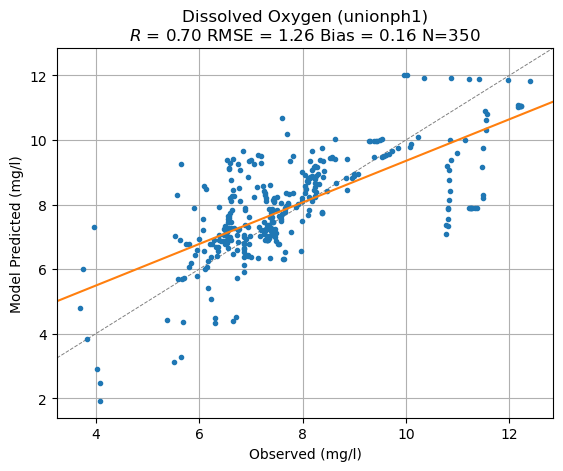

In [8]:
cum_stats = []
for pfx, label, data, unit in zip(('o2',),
        ("Dissolved Oxygen",),
        (o2_validation_df,),
        ("mg/l",)):
    if data.empty:
        continue
    fit, rsq, rmse, bias, n = vu.run_stats(data["observed"], data["model"])
    fig, ax = plt.subplots()
    vu.plot_fit(ax, data['observed'], data['model'], f'{label} ({run_name})', unit=unit)
    fig.savefig(out_file(f'{pfx}_validation.png'))
    cum_stats.append([label, rsq, rmse, bias, n])

display(pd.DataFrame(cum_stats, columns=["Metric","R","RMSE","Bias","n"]))